# Simple GAN - Dataset: EMNIST Letters

### Packages and Visualization

In [1]:
import torchvision.transforms.functional as Functional
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import EMNIST 
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch import nn
import torch

### Utility Function for Viewing Images

In [2]:
def show_tensor_images(image_tensor, num_images = 25, size = (1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Generator and Noise

In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, z_dim = 10, im_dim = 784, hidden_dim = 128):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            self.get_generator_block(input_dim = z_dim, output_dim = hidden_dim),
            self.get_generator_block(input_dim = hidden_dim, output_dim = hidden_dim * 2),
            self.get_generator_block(input_dim = hidden_dim * 2, output_dim = hidden_dim * 4),
            self.get_generator_block(input_dim = hidden_dim * 4, output_dim = hidden_dim * 8),
            nn.Linear(in_features = hidden_dim * 8, out_features = im_dim),
            nn.Sigmoid())
    
    def get_generator_block(self, input_dim, output_dim):
        '''
        Function for returning a block of the generator's neural network
        given input and output dimensions.
        Parameters:
            input_dim: the dimension of the input vector, a scalar
            output_dim: the dimension of the output vector, a scalar
        Returns:
            a generator neural network layer, with a linear transformation 
              followed by a batch normalization and then a relu activation
        '''

        return nn.Sequential(
            nn.Linear(in_features = input_dim, out_features = output_dim),
            nn.BatchNorm1d(num_features = output_dim),
            nn.ReLU(inplace = True))
    
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''

        return self.gen(noise)

In [4]:
def get_noise(n_samples, z_dim, device = 'cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''

    return torch.randn(n_samples, z_dim, device = device)

### Discriminator

In [5]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, im_dim = 784, hidden_dim = 128):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            self.get_discriminator_block(input_dim = im_dim, output_dim = hidden_dim * 4),
            self.get_discriminator_block(input_dim = hidden_dim * 4, output_dim = hidden_dim * 2),
            self.get_discriminator_block(input_dim = hidden_dim * 2, output_dim = hidden_dim),
            nn.Linear(in_features = hidden_dim, out_features = 1))

    def get_discriminator_block(self, input_dim, output_dim):
        '''
        Discriminator Block
        Function for returning a neural network of the discriminator given input and output dimensions.
        Parameters:
            input_dim: the dimension of the input vector, a scalar
            output_dim: the dimension of the output vector, a scalar
        Returns:
            a discriminator neural network layer, with a linear transformation 
              followed by an nn.LeakyReLU activation with negative slope of 0.2 
        '''

        return nn.Sequential(
            nn.Linear(in_features = input_dim, out_features = output_dim), 
            nn.LeakyReLU(negative_slope = 0.2, inplace = True))
    
    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''

        return self.disc(image)

### Training

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_step = 2500
batch_size = 128
lr = 0.00001
device = 'cuda'

transform = transforms.Compose(transforms =  [transforms.ToTensor(), transforms.ToPILImage(), 
                                              transforms.Lambda(lambda x: Functional.rotate(x, -90)), 
                                              transforms.RandomHorizontalFlip(p = 1), transforms.ToTensor()])

dataloader = DataLoader(EMNIST('.', download = True, transform = transform, split = 'letters'),
                        batch_size = batch_size, shuffle = True)

In [7]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(params = gen.parameters(), lr = lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(params = disc.parameters(), lr = lr)

In [8]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
                   the discriminator's predictions to the ground truth reality of the images 
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                    which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''

    fake_noise = get_noise(n_samples = num_images, z_dim = z_dim, device = device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    
    return disc_loss

In [9]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
                   the discriminator's predictions to the ground truth reality of the images 
        num_images: the number of images the generator should produce, 
                    which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''

    fake_noise = get_noise(n_samples = num_images, z_dim = z_dim, device = device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    
    return gen_loss

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.8281564319610613, discriminator loss: 0.2317637308388945


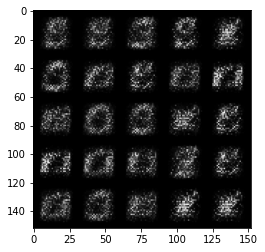

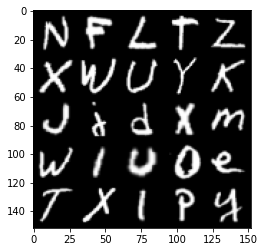

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 5000: Generator loss: 3.4037297621727, discriminator loss: 0.06590386596769103


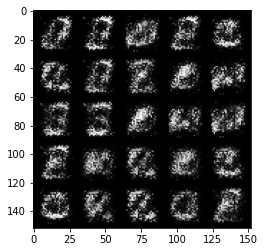

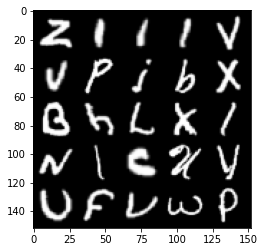

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 7500: Generator loss: 4.682283648872384, discriminator loss: 0.03900724708512425


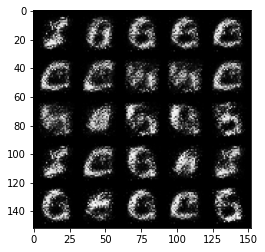

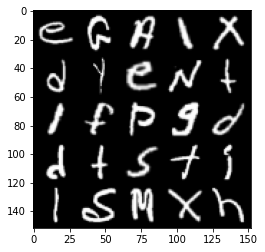

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 10000: Generator loss: 4.857722526931768, discriminator loss: 0.04285452249310913


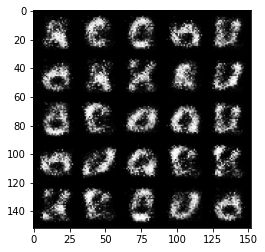

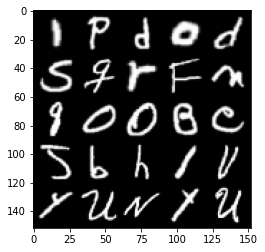

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 12500: Generator loss: 4.466380082702635, discriminator loss: 0.055633869217336165


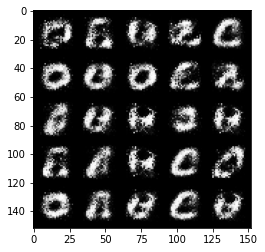

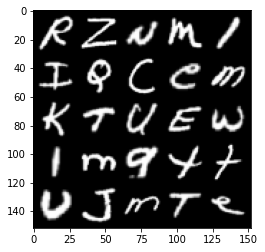

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 15000: Generator loss: 4.113605129337312, discriminator loss: 0.07911607506126181


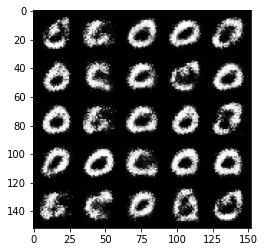

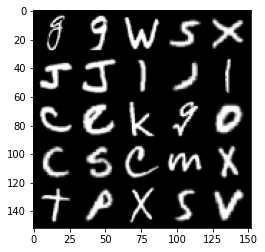

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 17500: Generator loss: 3.712537319850931, discriminator loss: 0.1231050712019207


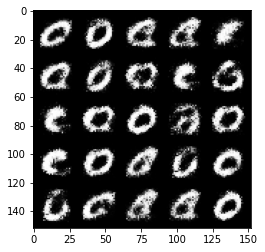

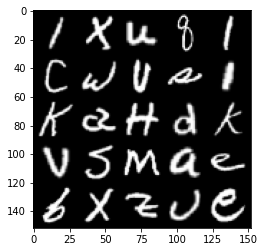

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 20000: Generator loss: 3.386669579410548, discriminator loss: 0.1640248856902124


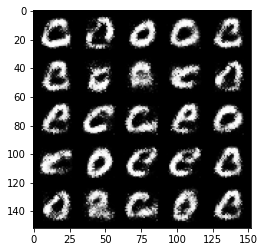

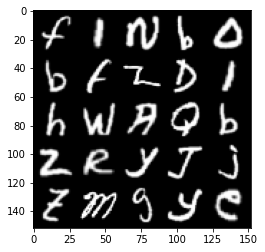

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 22500: Generator loss: 3.149732676792147, discriminator loss: 0.18869591121077517


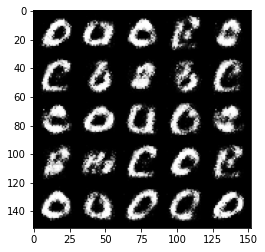

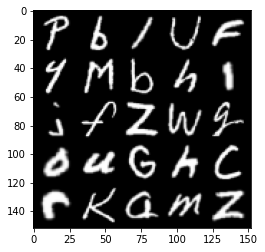

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 25000: Generator loss: 2.9929986115455627, discriminator loss: 0.208758776786923


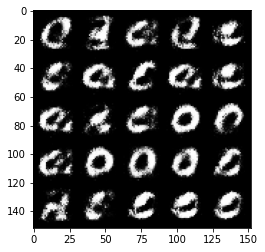

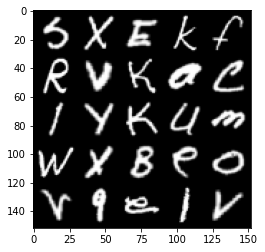

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 27500: Generator loss: 2.7977496811866756, discriminator loss: 0.22811524744629846


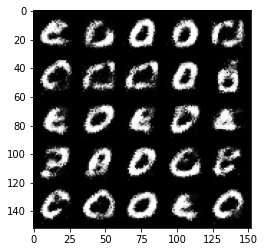

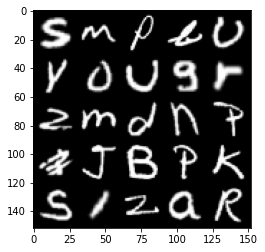

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 30000: Generator loss: 2.654713558578498, discriminator loss: 0.24501764518618588


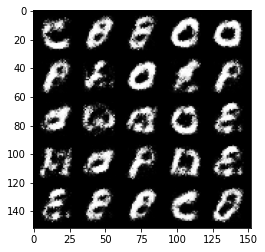

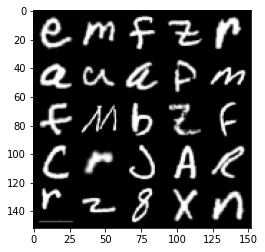

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 32500: Generator loss: 2.568117789220816, discriminator loss: 0.26017511463463294


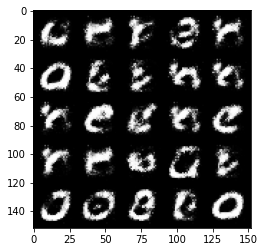

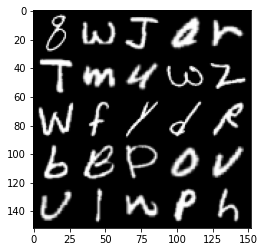

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 35000: Generator loss: 2.436825154209135, discriminator loss: 0.2710235057651996


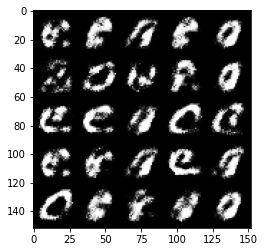

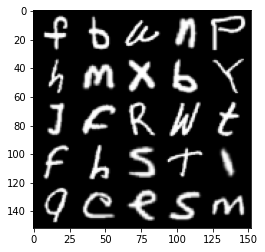

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 37500: Generator loss: 2.3928918232440917, discriminator loss: 0.2801312104940406


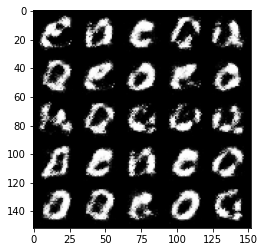

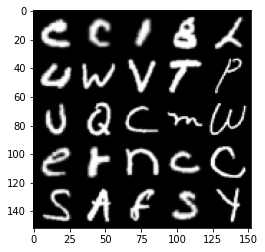

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 40000: Generator loss: 2.2653634758949273, discriminator loss: 0.3050746847212316


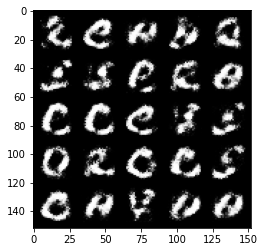

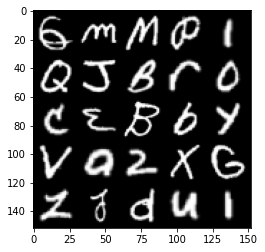

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 42500: Generator loss: 2.1989548863411006, discriminator loss: 0.3157881299316886


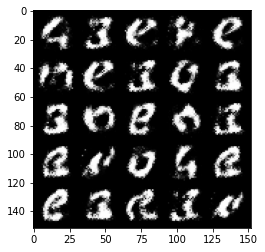

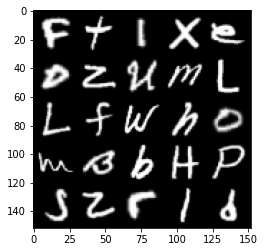

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 45000: Generator loss: 2.1480458382606513, discriminator loss: 0.3251102619707581


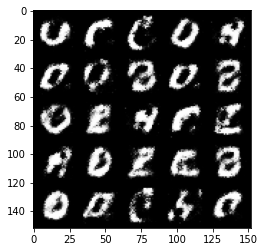

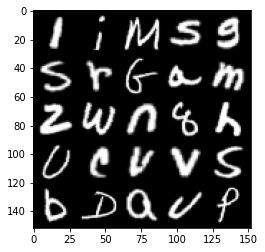

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 47500: Generator loss: 2.0757789149284327, discriminator loss: 0.3448517005205148


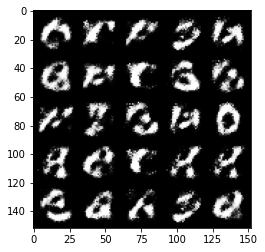

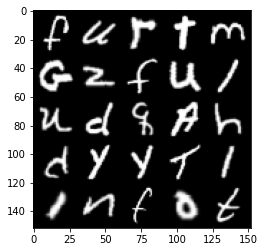

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 50000: Generator loss: 2.1014514904499073, discriminator loss: 0.33063325406909067


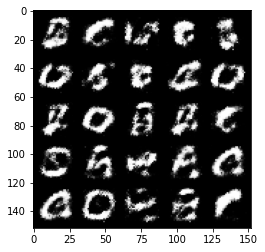

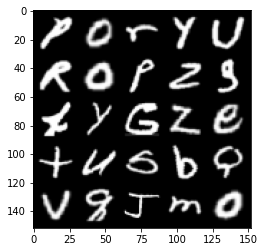

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 52500: Generator loss: 2.0574672194004098, discriminator loss: 0.3419675514757634


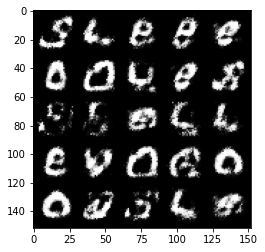

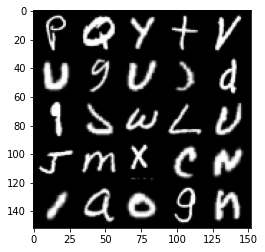

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 55000: Generator loss: 1.9274980870723717, discriminator loss: 0.3720967633366583


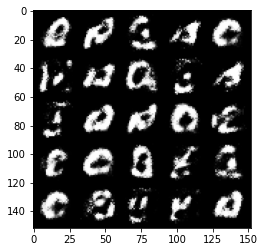

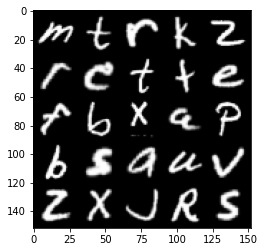

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 57500: Generator loss: 1.8775104211330418, discriminator loss: 0.37809979702830376


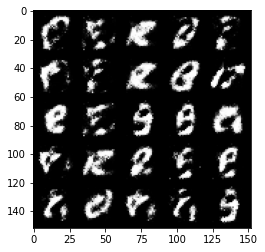

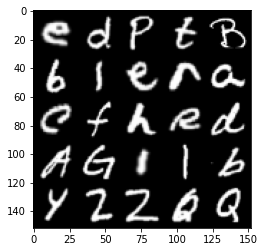

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 60000: Generator loss: 1.7657265057086915, discriminator loss: 0.40260273139476727


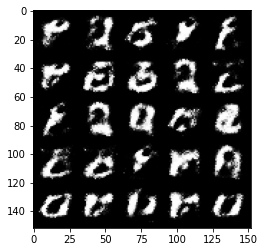

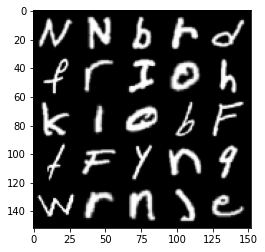

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 62500: Generator loss: 1.8220416312694547, discriminator loss: 0.3822954914808277


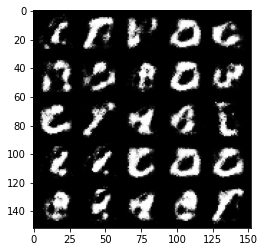

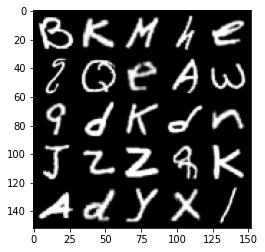

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 65000: Generator loss: 1.7495802798748037, discriminator loss: 0.39860190491676306


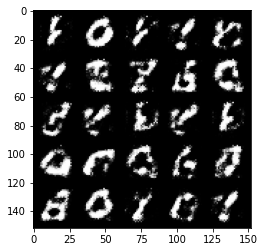

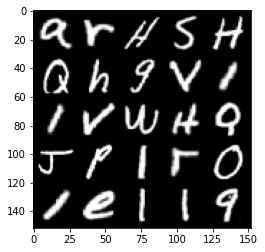

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 67500: Generator loss: 1.739958916711804, discriminator loss: 0.39924218853712107


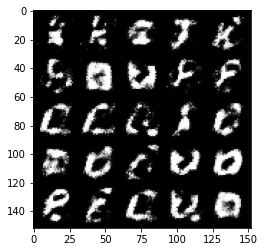

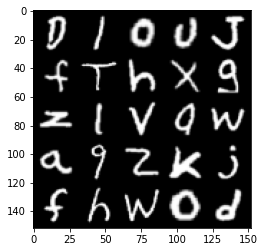

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 70000: Generator loss: 1.6403927472591402, discriminator loss: 0.4336156590819365


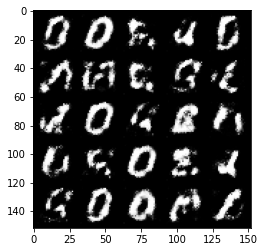

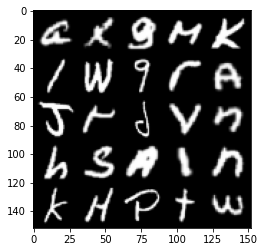

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 72500: Generator loss: 1.622706415224073, discriminator loss: 0.41833429002761885


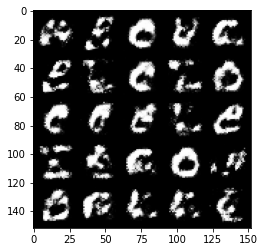

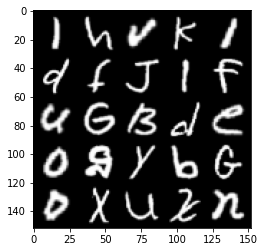

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 75000: Generator loss: 1.6118359645843483, discriminator loss: 0.42633848713636324


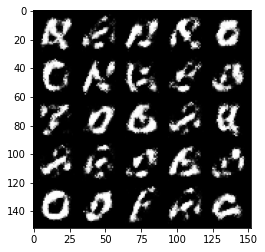

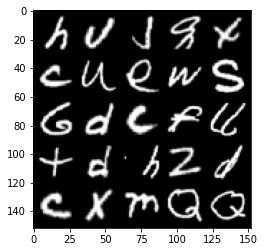

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 77500: Generator loss: 1.6265037390232058, discriminator loss: 0.42241267774105007


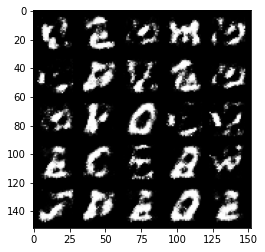

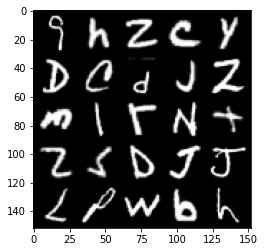

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 80000: Generator loss: 1.5004006840229034, discriminator loss: 0.45622181923389443


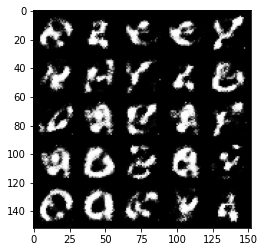

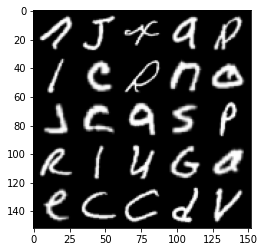

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 82500: Generator loss: 1.523191046810149, discriminator loss: 0.4418027545213703


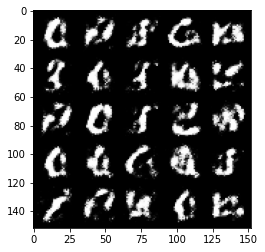

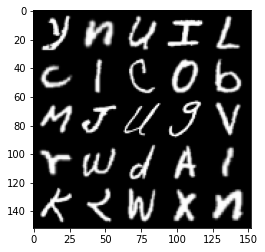

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 85000: Generator loss: 1.5310236463069884, discriminator loss: 0.44166759772300795


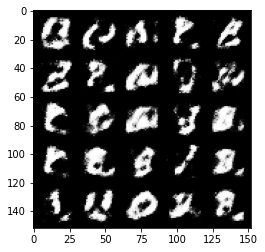

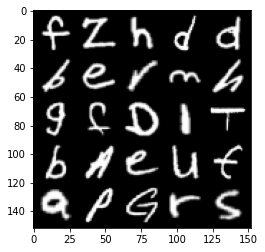

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 87500: Generator loss: 1.4723596005439714, discriminator loss: 0.4553022067070003


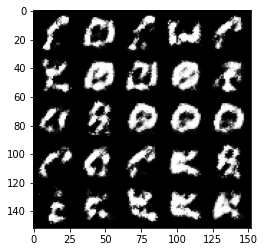

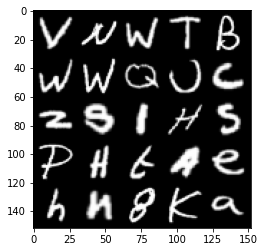

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 90000: Generator loss: 1.4796351540565513, discriminator loss: 0.4498916192173959


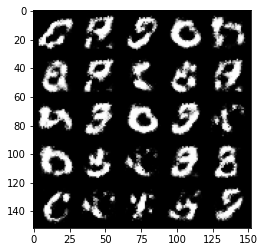

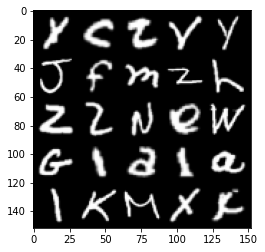

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 92500: Generator loss: 1.345539608955385, discriminator loss: 0.4913276918649675


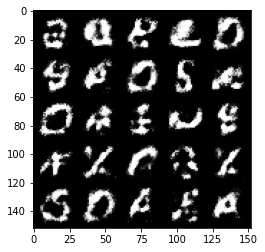

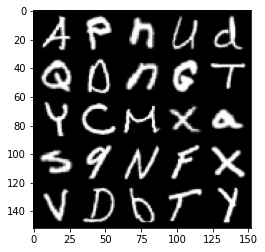

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

Step 95000: Generator loss: 1.3013171460390083, discriminator loss: 0.5004377299904824


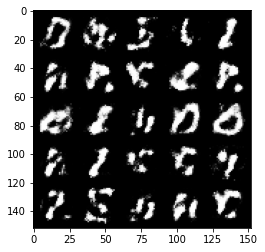

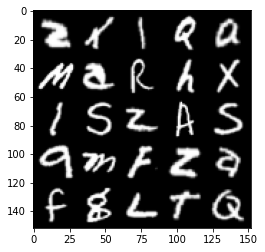

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

In [10]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True 
gen_loss = False
error = False

for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):

        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen = gen, disc = disc, criterion = criterion, 
                                  real = real, num_images = cur_batch_size, 
                                  z_dim = z_dim, device = device)

        # Update gradients
        disc_loss.backward(retain_graph = True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        # Update generator
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen = gen, disc = disc, criterion = criterion, 
                                num_images = cur_batch_size, z_dim = z_dim, 
                                device = device)
        gen_loss.backward()
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

### Save Model

In [11]:
torch.save(gen.state_dict(), f = 'gen_conditional_simple_gan_emnist_letters.pth')
torch.save(disc.state_dict(), f = 'disc_conditional_simple_gan_emnist_letters.pth')